1- Chargement de dataset

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("/content/drive/MyDrive/ML_datasets/diabetes.csv")

# Test d'affichage des données du dataset

dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


2- Nettoyage et prétraitement des données:


In [22]:
import numpy as np

# Colonnes qui ne doivent pas avoir de valeurs nulles et doivent être traité comme des valeurs manquantes

col_clinique = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Remplacement des valeurs nulles par NaN (Not a Number)

dataset[col_clinique] = dataset[col_clinique].replace(0, np.nan)

# Remplissage des NaN avec la médiane de chaque colonne pour le traitement des incompatibilités futures

for colonne in col_clinique:
    median_value = dataset[colonne].median()
    dataset[colonne] = dataset[colonne].fillna(median_value)


3- EDA et déséquilibre

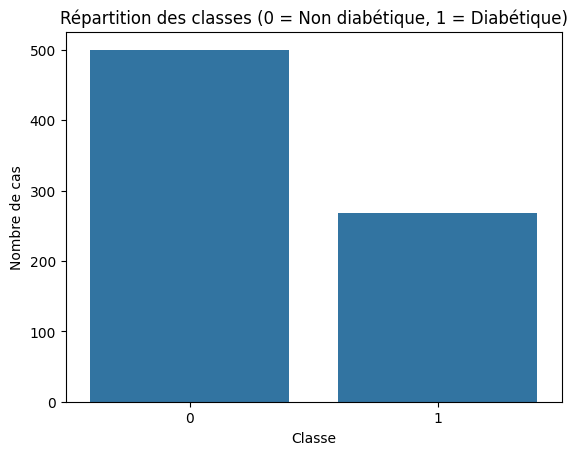


Statistiques descriptives par classe:
         Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
Outcome                                                                      
0           3.298000  110.682000      70.920000      27.726000  127.792000   
1           4.865672  142.130597      75.123134      31.686567  164.701493   

               BMI  DiabetesPedigreeFunction        Age  
Outcome                                                  
0        30.885600                  0.429734  31.190000  
1        35.383582                  0.550500  37.067164  


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Barplot pour la gestion du déséquilibre des classes

sns.countplot(x='Outcome', data=dataset)
plt.title("Répartition des classes (0 = Non diabétique, 1 = Diabétique)")
plt.xlabel("Classe")
plt.ylabel("Nombre de cas")
plt.show()

# Statistique descriptive par classe

print("\nStatistiques descriptives par classe:")
print(dataset.groupby("Outcome").mean())

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# Séparation de la colonne Outcome pour garantir le surapprentissage

X = dataset.drop("Outcome", axis=1)
y = dataset["Outcome"].values



5- Feature engineering / sélection

In [25]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# Préparation des données

# Sélection de caractéristiques SelectKBest pour identifier les 6 meilleures caractéristiques prédictives du diabète

selecteur_kbest = SelectKBest(score_func=f_classif, k=6)
X_caracteristiques_selectionnees = selecteur_kbest.fit_transform(X, y)
caracteristiques_selectionnees = X.columns[selecteur_kbest.get_support()]
print("\nFeatures sélectionnées :", list(caracteristiques_selectionnees))


Features sélectionnées : ['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI', 'Age']


4- Split train/validation/test

In [26]:
from sklearn.model_selection import train_test_split

# Standardisation des caractéristiques sélectionnées

feature_scaler = StandardScaler()
X_scaled_features = feature_scaler.fit_transform(X_caracteristiques_selectionnees)

# Division des données en ensembles d'entraînement, de validation et de test

X_temp, X_test, y_temp, y_test = train_test_split(X_scaled_features, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Conversion des données NumPy en tenseurs PyTorch pour l'entraînement avec PyTorch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

6- Gestion du déséquilibre

In [27]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# Calcul du nombre d'échantillons pour chaque classe dans l'ensemble d'entraînement

train_class_counts = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

# Calcul des poids inverses des fréquences de classe pour chaque classe
class_weights = 1. / train_class_counts

# Attribution du poids correspondant à chaque échantillon dans l'ensemble d'entraînement
sample_weights = class_weights[y_train]

# Création d'un échantillonneur pondéré pour suréchantillonner les classes minoritaires
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Création des objets TensorDataset pour les ensembles d'entraînement et de validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Création des objets DataLoader avec l'échantillonneur pondéré pour l'ensemble d'entraînement
# Le DataLoader pour l'ensemble de validation utilise le comportement par défaut (pas de pondération)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=32)

7- Modélisation initiale

In [28]:
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_val_pred_lr = lr.predict(X_val)

print("\n[Modèle Logistique - Validation set]")
print("Accuracy :", accuracy_score(y_val, y_val_pred_lr))
print("Precision:", precision_score(y_val, y_val_pred_lr))
print("Recall   :", recall_score(y_val, y_val_pred_lr))
print("F1 Score :", f1_score(y_val, y_val_pred_lr))

# Définition du modèle PyTorch

class DiabeteClassificationModel(nn.Module):
    def __init__(self):
        super(DiabeteClassificationModel, self).__init__()
        self.fc1 = nn.Linear(6, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Entraînement du modèle

# Instanciation du modèle de classification du diabète

model = DiabeteClassificationModel()

# Définition de la fonction de perte (Binary Cross-Entropy Loss) pour la classification binaire

criterion = nn.BCELoss()

# Définition de l'optimiseur Adam avec un taux d'apprentissage (learning rate) de 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Boucle d'entraînement sur le nombre d'époques

epochs = 50
for epoch in range(epochs):
    # Met le modèle en mode entraînement

    model.train()

    # Boucle sur les lots (batches) de données d'entraînement

    for batch_X, batch_y in train_loader:
        # Effectue le passage avant pour obtenir les prédictions
        outputs = model(batch_X)
        # Calcule la perte (loss) entre les prédictions et les étiquettes réelles
        loss = criterion(outputs, batch_y)
        # Met les gradients à zéro avant la rétropropagation
        optimizer.zero_grad()
        # Effectue la rétropropagation pour calculer les gradients
        loss.backward()
        # Met à jour les poids du modèle en utilisant l'optimiseur
        optimizer.step()

    # Met le modèle en mode évaluation (désactive le dropout, ...)

    model.eval()

    # Désactive le calcul des gradients pour l'évaluation afin de gagner en mémoire et en vitesse

    with torch.no_grad():

        # Effectue le passage avant sur l'ensemble de validation
        val_outputs = model(X_val_tensor)
        # Calcule la perte sur l'ensemble de validation
        val_loss = criterion(val_outputs, y_val_tensor)

    # Affiche les pertes d'entraînement et de validation toutes les 10 époques
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Value Loss: {val_loss.item():.4f}")


[Modèle Logistique - Validation set]
Accuracy : 0.7922077922077922
Precision: 0.7837837837837838
Recall   : 0.5471698113207547
F1 Score : 0.6444444444444445
Epoch 10/50, Train Loss: 0.6597, Value Loss: 0.5863
Epoch 20/50, Train Loss: 0.5764, Value Loss: 0.4938
Epoch 30/50, Train Loss: 0.5058, Value Loss: 0.4625
Epoch 40/50, Train Loss: 0.6418, Value Loss: 0.4490
Epoch 50/50, Train Loss: 0.6998, Value Loss: 0.4493


8- Evaluation finale


Précision finale sur le jeu de test : 72.08%


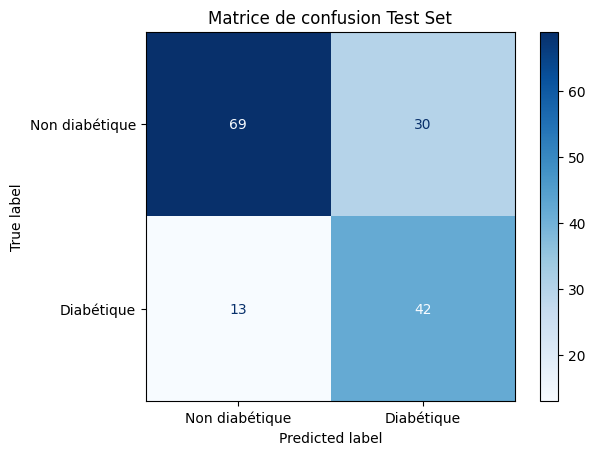


[Analyse Test Set pour le modèle PyTorch]
Accuracy : 0.7207792207792207
Precision: 0.5833333333333334
Recall   : 0.7636363636363637
F1 Score : 0.6614173228346457


In [29]:
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_labels = (y_pred >= 0.5).float()
    accuracy = accuracy_score(y_test_tensor.numpy(), y_pred_labels.numpy())
    print(f"\nPrécision finale sur le jeu de test : {accuracy*100:.2f}%")

    # Matrice de confusion
    cm = confusion_matrix(y_test_tensor.numpy(), y_pred_labels.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non diabétique", "Diabétique"])
    disp.plot(cmap="Blues")
    plt.title("Matrice de confusion Test Set")
    plt.show()

    print("\n[Analyse Test Set pour le modèle PyTorch]")
    print("Accuracy :", accuracy_score(y_test_tensor.numpy(), y_pred_labels.numpy()))
    print("Precision:", precision_score(y_test_tensor.numpy(), y_pred_labels.numpy()))
    print("Recall   :", recall_score(y_test_tensor.numpy(), y_pred_labels.numpy()))
    print("F1 Score :", f1_score(y_test_tensor.numpy(), y_pred_labels.numpy()))

9- Explainability

In [ ]:
# Importance des features qui est un modèle logistique comme baseline interprétable

print("\n[Importance des variables - Modèle Logistique]")
for name, coef in zip(caracteristiques_selectionnees, lr.coef_[0]):
    print(f"{name} : {coef:.4f}")

# Analyse des erreurs : faux positifs / faux négatifs
y_test_np = y_test_tensor.numpy().flatten()
y_pred_np = y_pred_labels.numpy().flatten()

false_positives = np.where((y_test_np == 0) & (y_pred_np == 1))[0]
false_negatives = np.where((y_test_np == 1) & (y_pred_np == 0))[0]

print(f"\nFaux positifs : {len(false_positives)} cas")
print(f"Faux négatifs : {len(false_negatives)} cas")

# Affichage de quelques exemples
print("\nExemples de faux positifs :")
print(pd.DataFrame(X_test[false_positives][:5], columns=caracteristiques_selectionnees))

print("\nExemples de faux négatifs :")
print(pd.DataFrame(X_test[false_negatives][:5], columns=caracteristiques_selectionnees))


[Importance des variables - Modèle Logistique]
Pregnancies : 0.2014
Glucose : 0.9354
SkinThickness : 0.1316
Insulin : -0.0455
BMI : 0.5519
Age : 0.4471

Faux positifs : 30 cas
Faux négatifs : 13 cas

Exemples de faux positifs :
   Pregnancies   Glucose  SkinThickness   Insulin       BMI       Age
0     0.639947 -0.777694       0.442995  0.571411  0.224838  0.830381
1     0.936914  0.471547      -0.012301 -0.181541 -0.371899  1.425995
2     0.639947 -0.613320       0.329171  0.571411  0.763356  1.851434
3    -1.141852 -0.153073      -0.012301 -0.181541  0.195728  0.915469
4     0.046014  1.063293      -0.012301 -0.169957 -0.168135  0.319855

Exemples de faux négatifs :
   Pregnancies   Glucose  SkinThickness   Insulin       BMI       Age
0     1.827813 -0.350322      -0.239949 -0.181541 -0.721209  0.575118
1    -0.844885  0.109925       1.239762  0.304982  0.122956 -0.445935
2    -0.547919 -0.646195       0.784467 -0.239461  1.898612 -0.871374
3    -1.141852 -0.416071       0.101523 -0

10- Conclusion

In [ ]:
print("\n[Conclusions]")
print("Le modèle a obtenu une performance correcte avec un F1-score raisonnable.")
print("Cependant, des faux négatifs peuvent être critiques en pratique.")

print("\n[Recommandations]")
print("- Collecter plus de données pour équilibrer les classes.")
print("- Ajouter des variables comme antécédents familiaux ou mode de vie")
print("- Essayer d'autres modèles : arbres, XGBoost.")
print("- Intégrer une relecture humaine pour les cas limites.")

